# Uncertainty quantification (UQ) in lung function model

In the following notebook, we asses the variability of our lung function ML model via sensitivity analysis (SA), main effects (ME), and forward uncertainty quantification tasks (UQ).

We begin by importing the necessary modules.

In [1]:
from IPython.display import clear_output

In [2]:
!pip install emukit
clear_output()
print('Emukit installed')

Emukit installed


In [3]:
!pip install SAlib
clear_output()
print('SAlib installed')

SAlib installed


In [4]:
!pip install pyDOE
clear_output()
print('pyDOE installed')

pyDOE installed


In [5]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axis import Axis
import matplotlib.ticker as ticker
from matplotlib import colors as mcolors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

np.random.seed(20)

In [6]:
# Emukit imports
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
import emukit.test_functions.multi_fidelity

In [7]:
# Sensitivity analysis imports
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

In [8]:
from matplotlib.ticker import StrMethodFormatter

In [9]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

Next, we import our trained ML model, which is based on a multi-fidelity GP approach,

In [14]:
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/CM3_save_permeability_c_50percent.pkl
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/CM3_save_permeability_r_50percent.pkl
!wget https://raw.githubusercontent.com/josebarahonay/datos_org/master/CM3_std_scaler_50percent.bin

--2023-07-31 14:58:10--  https://raw.githubusercontent.com/josebarahonay/datos_org/master/CM3_save_permeability_c_50percent.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1120505 (1.1M) [application/octet-stream]
Saving to: ‘CM3_save_permeability_c_50percent.pkl.1’

CM3_save_permeabili 100%[===================>]   1.07M  --.-KB/s    in 0.04s   

2023-07-31 14:58:10 (29.9 MB/s) - ‘CM3_save_permeability_c_50percent.pkl.1’ saved [1120505/1120505]

--2023-07-31 14:58:10--  https://raw.githubusercontent.com/josebarahonay/datos_org/master/CM3_save_permeability_r_50percent.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.c

In [10]:
model_path_c = '/content/drive/MyDrive/Colab Notebooks/UQ Lung/3 Uncertainty Quantification and Sensivity Analysis/CM3_save_permeability_c_50percent.pkl'
model_path_r = '/content/drive/MyDrive/Colab Notebooks/UQ Lung/3 Uncertainty Quantification and Sensivity Analysis/CM3_save_permeability_r_50percent.pkl'
scaler_path = '/content/drive/MyDrive/Colab Notebooks/UQ Lung/3 Uncertainty Quantification and Sensivity Analysis/CM3_std_scaler_50percent.bin'

In [18]:
import pickle
with open('CM3_save_permeability_c_50percent.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
surrogate_model_c = loaded_model

with open('CM3_save_permeability_r_50percent.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
surrogate_model_r = loaded_model

In [20]:
from joblib import dump, load

scaler=load('CM3_std_scaler_50percent.bin')

After imported, we define a `surrogate_evaluation` function, which allows us to evaluate a set of model parameters in our surrogate ML model and obtain the respiratory-system compliance or airways resistance.

In [21]:
def surrogate_evaluation(x1,x2,x3,x4,x5,x6,output):
  if output == 'c':
    surrogate_model = surrogate_model_c
  else:
    surrogate_model = surrogate_model_r
  matriz = np.zeros((1,6))
  matriz[0,0] = x1
  matriz[0,1] = x2
  matriz[0,2] = x3
  matriz[0,3] = x4
  matriz[0,4] = x5
  matriz[0,5] = x6
  scaled_matriz  = scaler.transform(matriz)
  x1 = scaled_matriz[0,0]
  x2 = scaled_matriz[0,1]
  x3 = scaled_matriz[0,2]
  x4 = scaled_matriz[0,3]
  x5 = scaled_matriz[0,4]
  x6 = scaled_matriz[0,5]
  x_params = np.array([x1, x2, x3, x4, x5, x6, 1])
  x_params = np.expand_dims(x_params, axis = 0)
  hf_mean_surrogate_model, hf_var_surrogate_model = surrogate_model.predict(x_params)
  Y = hf_mean_surrogate_model
  return Y

We check that our model succesfully predicts the expected response for the baseline model parameters.

In [22]:
print(surrogate_evaluation(356.7, 1.075, 278.2, 5.766, 10000, 0.08, output='c')) # respiratory-system compliance predictions
print(surrogate_evaluation(356.7, 1.075, 278.2, 5.766, 10000, 0.08, output='r')) # airways resistance predictions

[[93.94383596]]
[[3.81961384]]


## Sensitivity Analysis (SA)

To analyze the sensitivity of the pulmonary response to the model parameters, we use a global method using Sobol' indices, which allows us to quantify the impact of each parameter/variable on the response.

A highly used metric are the total effects indices $S_{T_{i}}$, which measure the contribution to the variance of $\boldsymbol{y}$ of an input parameter, as well as of its higher-order interactions with other parameters,
\begin{equation}
    %\begin{array}{cc}
    \quad S_{T_{i}} = \frac{V_{T_{i}}}{Var(y)}.
    %\end{array}
\end{equation}
\
In our case, we perform the described global sensitivity analysis using the SALib library in Python. For the input parameters and their ranges, we consider those specified in the following code cell,

In [23]:
# We consider a range of 50% around the mean
rango = 0.5

# Define the model inputs
problem = {
    'num_vars': 6,
    'names': ['c', 'beta', 'c1', 'c3', 'k', 'Ks'],
    'bounds': [[-rango*356.7 + 356.7 , 356.7 + rango*356.7],
               [-rango*1.075 + 1.075 , 1.075 + rango*1.075],
               [-rango*278.2 + 278.2 , 278.2 + rango*278.2],
               [-rango*5.766 + 5.766 , 5.766 + rango*5.766],
               [-rango*10000 + 10000 , 10000 + rango*10000],
               [-rango*0.08 + 0.08   , 0.08  + rango*0.08]]
}

Using Saltelli's sampling scheme, we generate a total of 28672 evaluations on our surrogate model, given by $N(2D+2)$, where $N$=2048 (number of samples) and $D$=6 (number of parameters). and then we compute the total sensitivity indices for C$_{\text{rs}}$ and ${\text{R}}$.

In [52]:
# Generate samples
param_values = saltelli.sample(problem, 2048)

# Run model
Y_sobol_C = np.array(list(map(lambda p: surrogate_evaluation(p[0], p[1], p[2], p[3], p[4], p[5], output='c'), param_values)))
Y_sobol_C = Y_sobol_C[:,0][:,0]
Y_sobol_R = np.array(list(map(lambda p: surrogate_evaluation(p[0], p[1], p[2], p[3], p[4], p[5], output='r'), param_values)))
Y_sobol_R = Y_sobol_R[:,0][:,0]

# Perform analysis
print("Resistance Sobol Indices")
R_Si_hf_gp = sobol.analyze(problem, Y_sobol_R, print_to_console = True) # Sobol indices for Resistance (R)
print("")
print("Compliance Sobol Indices")
C_Si_hf_gp = sobol.analyze(problem, Y_sobol_C, print_to_console = True) # Sobol indices for Compliance (C)

# Extract values for Sobol' total indices (ST)
ST_R_CM3 = R_Si_hf_gp['ST']
conf_R_CM3 = R_Si_hf_gp['ST_conf']
ST_C_CM3 = C_Si_hf_gp['ST']
conf_C_CM3 = C_Si_hf_gp['ST_conf']

Resistance Sobol Indices
            ST   ST_conf
c     0.003566  0.000432
beta  0.001874  0.000285
c1    0.001377  0.000149
c3    0.001130  0.000143
k     0.992060  0.038751
Ks    0.002736  0.000411
            S1   S1_conf
c     0.001235  0.003365
beta -0.000084  0.002496
c1   -0.001838  0.002124
c3   -0.000391  0.002127
k     0.990158  0.063909
Ks   -0.000570  0.003403
                  S2   S2_conf
(c, beta)   0.000523  0.005737
(c, c1)     0.000412  0.005712
(c, c3)     0.000350  0.005701
(c, k)      0.000568  0.006591
(c, Ks)     0.000487  0.005739
(beta, c1) -0.000663  0.003757
(beta, c3) -0.000925  0.003773
(beta, k)   0.000601  0.004213
(beta, Ks) -0.000951  0.003806
(c1, c3)    0.001753  0.003345
(c1, k)     0.001623  0.003313
(c1, Ks)    0.001539  0.003305
(c3, k)     0.000641  0.003225
(c3, Ks)    0.000261  0.002634
(k, Ks)     0.003132  0.088958

Compliance Sobol Indices
            ST   ST_conf
c     0.449480  0.039353
beta  0.128186  0.010712
c1    0.000502  0.000078
c3 

In [53]:
cmap_2 = plt.cm.get_cmap('GnBu')

rgba_4 = cmap_2(0.99)
rgba_3 = cmap_2(0.75)
rgba_6 = cmap_2(0.5)

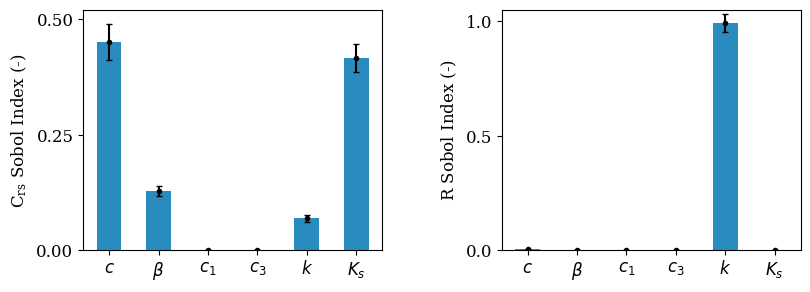

<Figure size 640x480 with 0 Axes>

In [54]:
# Plotting Sobol' indices
fig, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(7.9, 3)
fig.tight_layout()

bars_CM3 = ('$c$',r'$\beta$','$c_1$','$c_3$','$k$','$K_s$')

ax1.bar(bars_CM3, ST_C_CM3, color = rgba_3, width = 0.5)
ax1.errorbar(bars_CM3, ST_C_CM3, yerr=conf_C_CM3, fmt=".", color="k", capsize = 2)
ax1.set_ylim(0,0.52)
ax1.set_yticks(np.linspace(0,0.5,3))
ax1.set_ylabel("$\mathregular{C_{rs}}$ Sobol Index (-)", size = 12, labelpad = 5)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax2.bar(bars_CM3, ST_R_CM3, color = rgba_3, width = 0.5)
ax2.errorbar(bars_CM3, ST_R_CM3, yerr=conf_R_CM3, fmt=".", color="k", capsize = 2)
ax2.set_ylim(0,1.05)
ax2.set_yticks(np.linspace(0,1,3))
ax2.set_ylabel("$\mathregular{R}$ Sobol Index (-)", size = 12, labelpad = 5)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

plt.subplots_adjust(wspace=0.4)

plt.show()
plt.draw()

fig.savefig("sobol_indices.png", bbox_inches='tight', dpi=600)

## Main Effects (ME)

Furthermore, we want to observe how one of the model inputs (parameters) affects the output when all other parameters are averaged. To accomplish this, using our ML surrogate model we compute the main effects of each model parameter, $z(X_i)=E(\boldsymbol{y}|X_i)-E(\boldsymbol{y})$. To approximate this metric, we sample 100 trajectories from a latin hypercube design over the parameter space limited by the previously specified range, varying the input $X_i$ to compute the main effects across the parameter space.

In [55]:
cmap_2 = plt.cm.get_cmap('GnBu')
rgba_4 = cmap_2(0.75)

<Figure size 640x480 with 0 Axes>

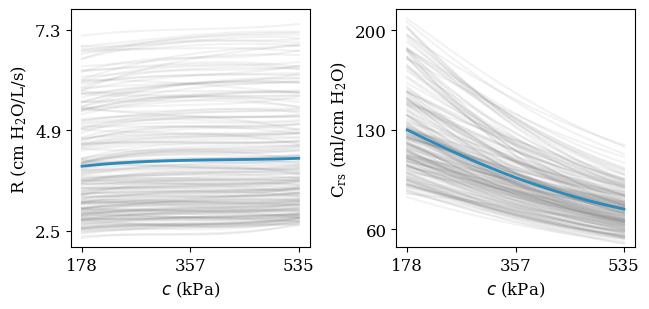

<Figure size 640x480 with 0 Axes>

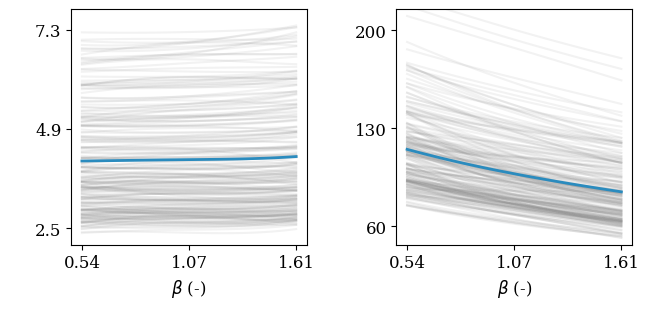

<Figure size 640x480 with 0 Axes>

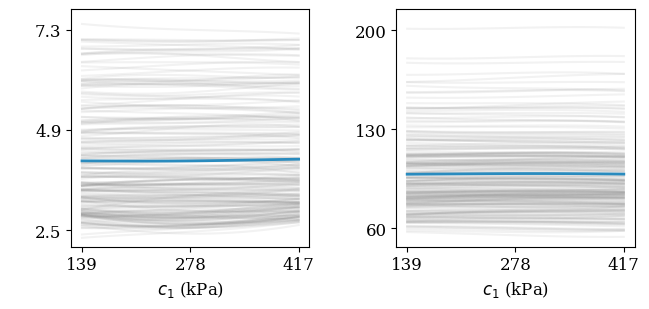

<Figure size 640x480 with 0 Axes>

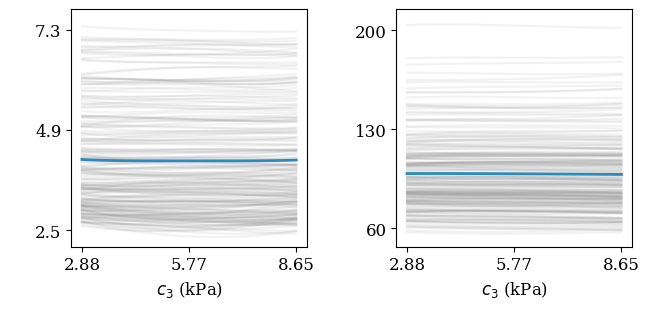

<Figure size 640x480 with 0 Axes>

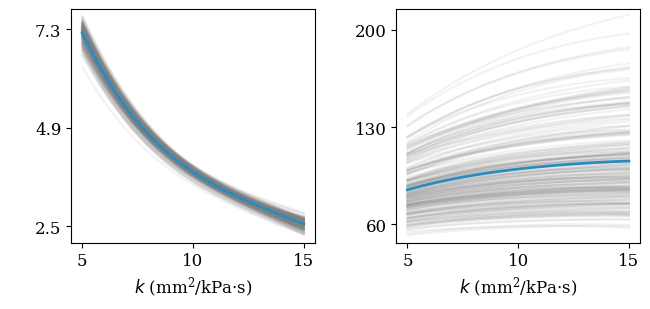

<Figure size 640x480 with 0 Axes>

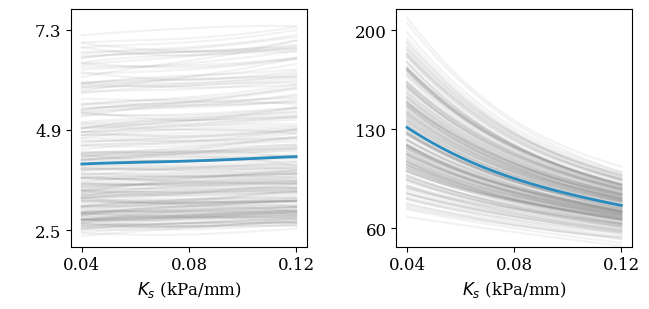

In [ ]:
from pyDOE import lhs

# Generate samples from LHS
np.random.seed(2)
bounds = np.array(problem['bounds'])
params = bounds[:,0] + (bounds[:,1] - bounds[:,0])*lhs(6,200)

# Use the samples to compute the main effects across the parameter space
X = np.linspace(0,1, 100)
names = ['$c$ (kPa)',r'$\beta$ (-)','$c_1$ (kPa)','$c_3$ (kPa)','$k$ ($\mathregular{mm^{2}}$/kPa$\cdot$s)','$K_s$ (kPa/mm)']
for d in range(6):
  plt.figure()
  params_edit = params.copy()
  Lines_R = []
  Lines_C = []
  fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(6.6, 3.2))
  for p in params_edit:
    line_R = []
    line_C = []
    X_d = bounds[d,0] + (bounds[d, 1] - bounds[d, 0])*X
    for x in X_d:
      p[d] = x
      Y_C = surrogate_evaluation(p[0], p[1], p[2], p[3], p[4], p[5], output='c')[0][0]
      Y_R = surrogate_evaluation(p[0], p[1], p[2], p[3], p[4], p[5], output='r')[0][0]
      #Y_R = Y_C[:,0]
      #Y_C = Y_C[:,0]
      line_R.append(Y_R)
      line_C.append(Y_C)
    Lines_R.append(line_R)
    Lines_C.append(line_C)
    ax1.plot(X_d, line_R, 'grey', alpha = 0.1)
    ax2.plot(X_d, line_C, 'grey', alpha = 0.1)
  if d!=0:
    ax1.set_ylabel('$\mathregular{R}$ (cm $\mathregular{H_2O}$/L/s)', size = 12, color='white')
    ax2.set_ylabel('$\mathregular{C_{rs}}$ (ml/cm $\mathregular{H_2O}$)', fontsize=12, color='white')
  else:
    ax1.set_ylabel('$\mathregular{R}$ (cm $\mathregular{H_2O}$/L/s)', size = 12,)
    ax2.set_ylabel('$\mathregular{C_{rs}}$ (ml/cm $\mathregular{H_2O}$)', fontsize=12)
  ax1.set_xlabel(names[d],fontsize=12)
  ax1_minor_ticks_left=np.linspace(3,5,3)
  ax1.set_yticks(ax1_minor_ticks_left)
  ax2.set_xlabel(names[d], fontsize=12)
  ax2.plot(X_d, np.mean(Lines_C, axis = 0), color = rgba_4, linewidth = 2)
  ax1.plot(X_d, np.mean(Lines_R, axis = 0), color = rgba_4, linewidth = 2)
  xmin_r, xmax_r = ax1.get_xlim()
  xmin_c, xmax_c = ax2.get_xlim()
  ax1.set_xlim(xmin_r, xmax_r)
  ax2.set_ylim(xmin_c, xmax_c)
  #if d == 0:
    #ax1.set_xticks(np.linspace(bounds[d,0], bounds[d,1], 3))
    #ax2.set_xticks(np.linspace(bounds[d,0], bounds[d,1], 3))
  ax1.set_xticks(np.linspace(min(X_d), max(X_d), 3))
  ax2.set_xticks(np.linspace(min(X_d), max(X_d), 3))
  ax2_minor_ticks_left=np.linspace(60,200,3)
  ax2.set_yticks(ax2_minor_ticks_left)
  ax1.set_ylim(2.1, 7.8)
  ax2.set_ylim(47,215)
  ax1.set_yticks(np.linspace(2.5,7.3,3))
  if d == 0:
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
  elif d == 1:
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
  elif d == 2:
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
  elif d == 3:
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
  elif d == 4:
    #ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    #ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    labels_1 = [item.get_text() for item in ax1.get_xticklabels()]
    labels_2 = [item.get_text() for item in ax1.get_xticklabels()]
    labels_1[0] = str(int(min(X_d)/1000))
    labels_1[1] = str(int((min(X_d) + max(X_d))/2000))
    labels_1[2] = str(int(max(X_d)/1000))
    ax1.set_xticklabels(labels_1)
    labels_2[0] = str(int(min(X_d)/1000))
    labels_2[1] = str(int((min(X_d) + max(X_d))/2000))
    labels_2[2] = str(int(max(X_d)/1000))
    ax2.set_xticklabels(labels_2)
    #ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    #ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
  elif d == 5:
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
  ax1.tick_params(axis='x', labelsize=12)
  ax1.tick_params(axis='y', labelsize=12)
  ax2.tick_params(axis='x', labelsize=12)
  ax2.tick_params(axis='y', labelsize=12)
  fig.tight_layout()
  fig.savefig(str(d)+'.png', dpi=600, bbox_inches='tight')

## Forward Uncertainty Quantification (UQ)

A crucial task in our work is to propagate the uncertainties considered in the input parameters and quantify their impact on the output/lung response. This approach is usually called forward uncertainty quantification (UQ).

Specifically, we sample from distributions defined for each input parameter, propagate these through our surrogate ML model, and then compute the empirical distribution of the response, $\boldsymbol{y}$, thus having a problem of the form,

\begin{equation}
        p(\boldsymbol{y}) = p(f(\boldsymbol{X}))
\end{equation}

where $p(\boldsymbol{y})$ is the probability of the response and $f(\boldsymbol{X})$ represents the mapping of our ML surrogate model from the input parameters to the lung response.

- We assume that each parameter follows a uniform distribution function of the form $x_{i} \sim U[a_{i}, b_{i}]$, where $a_{i}$ and $b{i}$ are the lower and upper ranges for each parameter $x_{i} \in \boldsymbol{X}$.

- To choose the distribution sample size, we use as a criterion the coefficient of variation $\text{CV} = \sigma/\mu$, where $\sigma$ is the standard deviation of the means of a number $m$ of uniform distributions each with sample size $n$, and $\mu$ is the average value of these means. Here, we choose $m$ = 1000, and considering a criterion of $\text{CV} < 0.5\%$ as acceptable for the mean to be representative of the distributions, we vary the number of samples from $n$ = 100 to 10000. With this considerations, the criterion is achieved for $n$ = 10000 samples, with a $\text{CV} = 0.18\%$.

In [56]:
np.set_printoptions(suppress=True)

In [57]:
rgba_5 = cmap_2(0.75)
rgba_6 = cmap_2(0.5)

### Example case

As an example, in the following code cell, using our ML model we propagate a 25% uncertainty in input parameter $c$, and then we obtain variability distributions for the respiratory-system compliance $\mathrm{C_{rs}}$ and airways resistance $\mathrm{R}$.

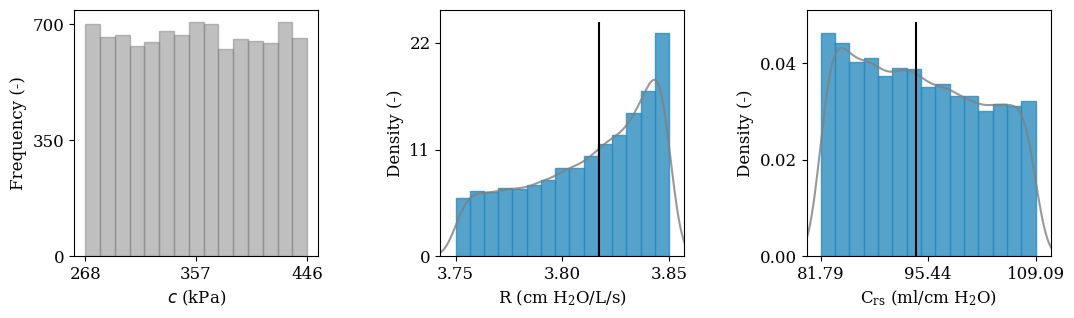

In [82]:
# Specify number of samples
N_samples = 10000

# Level of uncertainty
noise_list = [0.25]

datos = np.zeros((1,5))
i = 0
parametros_r_list = []
parametros_c_list = []

# For each parameter, we sample from uniform distributions
for noise_level in noise_list:
  # c
  mu_c = 356.7
  c_s = np.random.uniform(-noise_level*mu_c+mu_c,mu_c+noise_level*mu_c,N_samples)
  # β
  mu_beta = 1.075
  beta_s = mu_beta + 0*np.random.uniform(-noise_level*mu_beta+mu_beta,mu_beta+noise_level*mu_beta,N_samples)
  # c1
  mu_c1 = 278.2
  c1_s = mu_c1 + 0*np.random.uniform(-noise_level*mu_c1+mu_c1,mu_c1+noise_level*mu_c1,N_samples)
  # c3
  mu_c3 = 5.766
  c3_s = mu_c3 + 0*np.random.uniform(-noise_level*mu_c3+mu_c3,mu_c3+noise_level*mu_c3,N_samples)
  # k
  mu_k = 10000
  k_s = mu_k + 0*np.random.uniform(-noise_level*mu_k+mu_k,mu_k+noise_level*mu_k,N_samples)
  # Ks
  mu_Ks = 0.08
  Ks_s = mu_Ks + 0*np.random.uniform(-noise_level*mu_Ks+mu_Ks,mu_Ks+noise_level*mu_Ks,N_samples)

  # Evaluate our sampled parameters in our ML surrogate model
  parametros_r = np.asarray([surrogate_evaluation(c, beta, c1, c3, k, Ks, output = 'r') for c, beta, c1, c3, k, Ks in zip(c_s, beta_s, c1_s, c3_s, k_s, Ks_s)])
  parametros_c = np.asarray([surrogate_evaluation(c, beta, c1, c3, k, Ks, output = 'c') for c, beta, c1, c3, k, Ks in zip(c_s, beta_s, c1_s, c3_s, k_s, Ks_s)])

  parametros_r = parametros_r[:,0][:,0]
  parametros_c = parametros_c[:,0][:,0]

  mean_parametros_r = surrogate_evaluation(mu_c, mu_beta, mu_c1, mu_c3, mu_k, mu_Ks, output = 'r')[:][0]
  mean_parametros_c = surrogate_evaluation(mu_c, mu_beta, mu_c1, mu_c3, mu_k, mu_Ks, output = 'c')[:][0]

  parametros_r_list.append(parametros_r)
  parametros_c_list.append(parametros_c)


### Plotting results ###
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(4.2*3, 3.2)
axs = axs.ravel()

# Uncertainty in c
axs[0].hist(c_s, alpha = 0.5, bins = 15, color = 'grey', ec = 'grey')
ymin_c, ymax_c = plt.ylim()
axs[0].vlines(mu_c, 0, ymax_c, linewidth = 1.5, color='k')
axs[0].set_xlabel('$c$ (kPa)', size = 12)
axs[0].set_ylabel('Frequency (-)', size = 12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_xticks([min(c_s), np.mean(c_s), max(c_s)])
axs[0].set_yticks(np.linspace(0,700,3))
axs[0].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # 2 decimal places

# Variability in R
sns.kdeplot(parametros_r_list[0], fill = False, color='grey', alpha=0.8, linewidth=1.5, ax = axs[1])
axs[1].hist(parametros_r_list[0], alpha = 0.8, density = True, color = rgba_5, bins = 15, ec=rgba_5)
axs[1].set_xlabel('$\mathregular{R}$ (cm $\mathregular{H_2O}$/L/s)', size = 12)
axs[1].set_ylabel('Density (-)', size = 12)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
ymin_r, ymax_r = axs[1].get_ylim()
axs[1].vlines(mean_parametros_r, 0, ymax_r, linewidth = 1.5, color='k')
axs[1].set_xticks(np.linspace(min(parametros_r_list[0]),max(parametros_r_list[0]),3))
axs[1].set_yticks(np.linspace(0,22,3))
axs[1].set_xlim(3.748, 3.858)
axs[1].xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

# Variability in Crs
sns.kdeplot(parametros_c_list[0], fill = False, color='grey', alpha=0.8, linewidth=1.5, ax=axs[2])
axs[2].hist(parametros_c_list[0], alpha = 0.8, density = True, color = rgba_5, bins = 15, ec=rgba_5)
axs[2].set_xlabel('$\mathregular{C_{rs}}$ (ml/cm $\mathregular{H_2O}$)', size = 12)
axs[2].set_ylabel('Density (-)', size = 12)
axs[2].tick_params(axis='x', labelsize=12)
axs[2].tick_params(axis='y', labelsize=12)
ymin_c, ymax_c = axs[2].get_ylim()
axs[2].vlines(mean_parametros_c, 0, ymax_c, linewidth = 1.5, color='k')
axs[2].set_xticks(np.linspace(min(parametros_c_list[0]),max(parametros_c_list[0]),3))
axs[2].set_yticks(np.linspace(0,0.04,3))
axs[2].set_xlim(80, 111)
axs[2].xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.subplots_adjust(wspace=0.5)
plt.savefig("uncertainty_example.png", dpi=600, bbox_inches='tight')
plt.show()

### Uncertainty quantification for all parameters

Now, we extend the previous example, but for all model parameters. In addition, we want to consider three levels of uncertainty in them: [10%, 25%, 50%]

In [112]:
cmap_2 = plt.cm.get_cmap('GnBu')

rgba_4 = cmap_2(0.99)
rgba_5 = cmap_2(0.7)
rgba_6 = cmap_2(0.45)

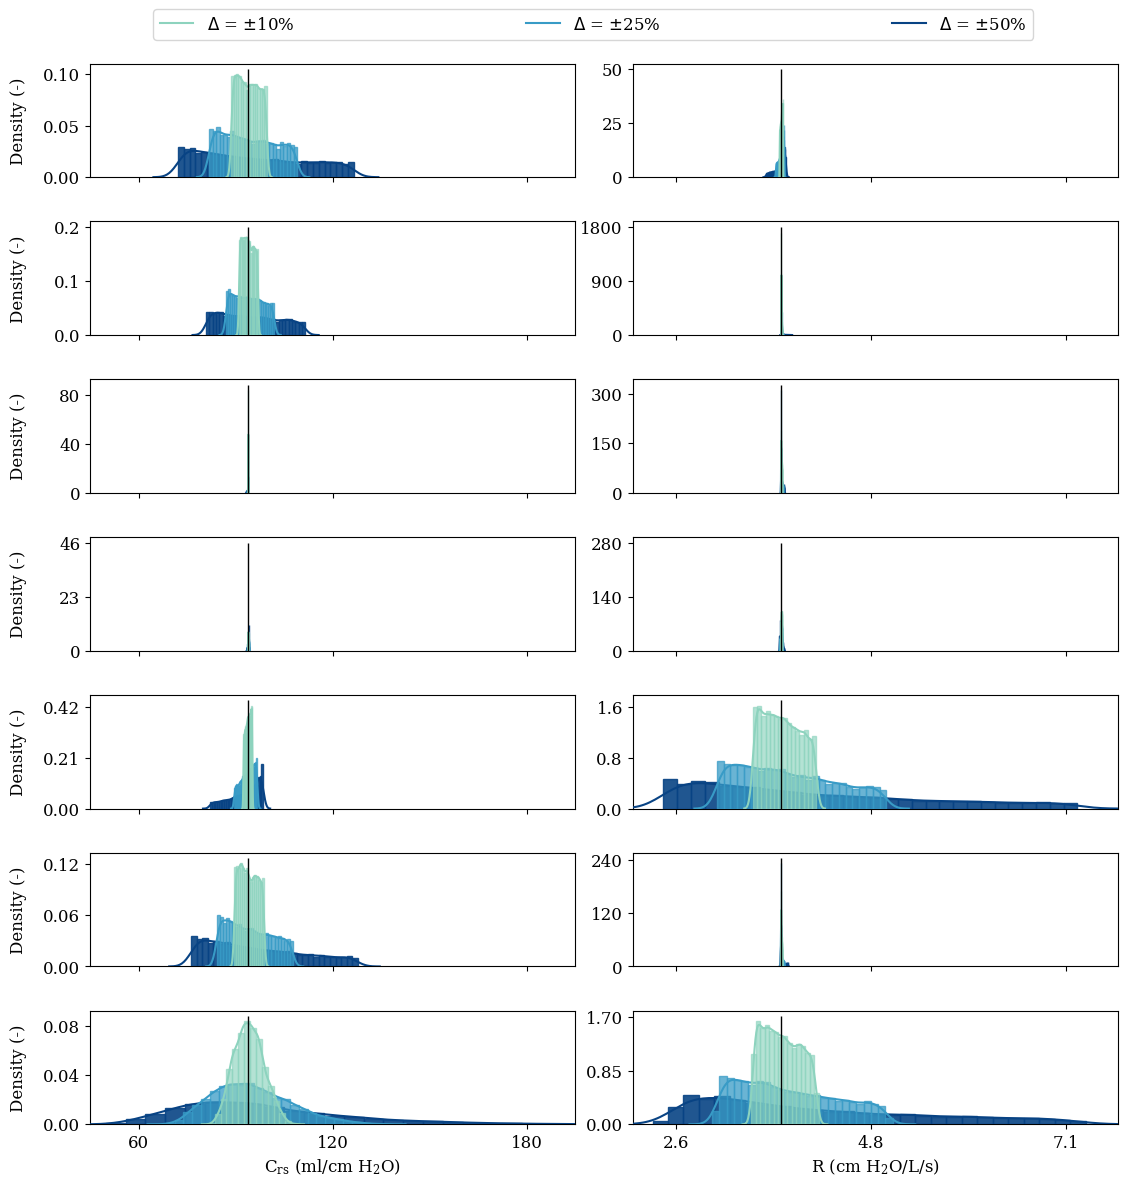

In [129]:
fig, axs = plt.subplots(nrows=7, ncols=2)
fig.set_size_inches(5.5*2, 1.6*7)
fig.tight_layout()

parametros = ["c", "beta", "c1", "c3", "k", "Ks", "all"] # model parameters list

N_samples = 10000
noise_list = [0.1, 0.25, 0.5] # corresponding to 10%, 25%, and 50% of uncertainty in model parameters
datos = np.zeros((3,5))
i = 0
parametros_r_list = []
parametros_c_list = []

for p in range(len(parametros)):
  parametros_r_list = []
  parametros_c_list = []
  for noise_level in noise_list:
    #c
    mu_c = 356.7
    if parametros[p] == "c":
      c_s = np.random.uniform(-noise_level*mu_c+mu_c,mu_c+noise_level*mu_c,N_samples)
    else:
      c_s = mu_c + 0*np.random.uniform(-noise_level*mu_c+mu_c,mu_c+noise_level*mu_c,N_samples)

    #beta
    mu_beta = 1.075
    if parametros[p] == "beta":
      beta_s = np.random.uniform(-noise_level*mu_beta+mu_beta,mu_beta+noise_level*mu_beta,N_samples)
    else:
      beta_s = mu_beta + 0*np.random.uniform(-noise_level*mu_beta+mu_beta,mu_beta+noise_level*mu_beta,N_samples)

    #c1
    mu_c1 = 278.2
    if parametros[p] == "c1":
      c1_s = np.random.uniform(-noise_level*mu_c1+mu_c1,mu_c1+noise_level*mu_c1,N_samples)
    else:
      c1_s = mu_c1 + 0*np.random.uniform(-noise_level*mu_c1+mu_c1,mu_c1+noise_level*mu_c1,N_samples)

    #c3
    mu_c3 = 5.766
    if parametros[p] == "c3":
      c3_s = np.random.uniform(-noise_level*mu_c3+mu_c3,mu_c3+noise_level*mu_c3,N_samples)
    else:
      c3_s = mu_c3 + 0*np.random.uniform(-noise_level*mu_c3+mu_c3,mu_c3+noise_level*mu_c3,N_samples)

    #k
    mu_k = 10000
    if parametros[p] == "k":
      k_s = np.random.uniform(-noise_level*mu_k+mu_k,mu_k+noise_level*mu_k,N_samples)
    else:
      k_s = mu_k + 0*np.random.uniform(-noise_level*mu_k+mu_k,mu_k+noise_level*mu_k,N_samples)

    #Ks
    mu_Ks = 0.08
    if parametros[p] == "Ks":
      Ks_s = np.random.uniform(-noise_level*mu_Ks+mu_Ks,mu_Ks+noise_level*mu_Ks,N_samples)
    else:
      Ks_s = mu_Ks + 0*np.random.uniform(-noise_level*mu_Ks+mu_Ks,mu_Ks+noise_level*mu_Ks,N_samples)

    #All
    if parametros[p] == "all":
      c_s = np.random.uniform(-noise_level*mu_c+mu_c,mu_c+noise_level*mu_c,N_samples)
      beta_s = np.random.uniform(-noise_level*mu_beta+mu_beta,mu_beta+noise_level*mu_beta,N_samples)
      c1_s = np.random.uniform(-noise_level*mu_c1+mu_c1,mu_c1+noise_level*mu_c1,N_samples)
      c3_s = np.random.uniform(-noise_level*mu_c3+mu_c3,mu_c3+noise_level*mu_c3,N_samples)
      k_s = np.random.uniform(-noise_level*mu_k+mu_k,mu_k+noise_level*mu_k,N_samples)
      Ks_s = np.random.uniform(-noise_level*mu_Ks+mu_Ks,mu_Ks+noise_level*mu_Ks,N_samples)

    parametros_r = np.asarray([surrogate_evaluation(c, beta, c1, c3, k, Ks, output = 'r') for c, beta, c1, c3, k, Ks in zip(c_s, beta_s, c1_s, c3_s, k_s, Ks_s)])
    parametros_c = np.asarray([surrogate_evaluation(c, beta, c1, c3, k, Ks, output = 'c') for c, beta, c1, c3, k, Ks in zip(c_s, beta_s, c1_s, c3_s, k_s, Ks_s)])

    parametros_r = parametros_r[:,0][:,0]
    parametros_c = parametros_c[:,0][:,0]

    mean_parametros_r = surrogate_evaluation(mu_c, mu_beta, mu_c1, mu_c3, mu_k, mu_Ks, output = 'r')[:][0]
    mean_parametros_c = surrogate_evaluation(mu_c, mu_beta, mu_c1, mu_c3, mu_k, mu_Ks, output = 'c')[:][0]

    parametros_r_list.append(parametros_r)
    parametros_c_list.append(parametros_c)

  # Plotting
  if parametros[p] == "c":
    sns.kdeplot(parametros_r_list[0], ax = axs[p,1], fill = False, color=rgba_6, label='$\Delta$ = $\pm$10%', alpha=1, linewidth=1.5, zorder = 60)
  else:
    sns.kdeplot(parametros_r_list[0], ax = axs[p,1], fill = False, color=rgba_6, alpha=1, linewidth=1.5, zorder = 60)
  axs[p,1].hist(parametros_r_list[0], alpha = 0.65, density = True, color = rgba_6, ec = rgba_6, bins = 15, zorder = 50)
  if parametros[p] == "c":
    sns.kdeplot(parametros_r_list[1], ax = axs[p,1], fill = False, color=rgba_5, label='$\Delta$ = $\pm$25%', alpha=1, linewidth=1.5, zorder = 30)
  else:
    sns.kdeplot(parametros_r_list[1], ax = axs[p,1], fill = False, color=rgba_5, alpha=1, linewidth=1.5, zorder = 30)
  axs[p,1].hist(parametros_r_list[1], alpha = 0.75, density = True, color = rgba_5, ec = rgba_5, bins = 25, zorder = 20)
  if parametros[p] == "c":
    sns.kdeplot(parametros_r_list[2], ax = axs[p,1], fill = False, color=rgba_4, label='$\Delta$ = $\pm$50%', alpha=1, linewidth=1.5, zorder = 15)
  else:
    sns.kdeplot(parametros_r_list[2], ax = axs[p,1], fill = False, color=rgba_4, alpha=1, linewidth=1.5, zorder = 15)
  axs[p,1].hist(parametros_r_list[2], alpha = 0.9, density = True, color = rgba_4, ec = rgba_4, bins = 30, zorder = 10)
  if parametros[p] == "c":
    axs[p,1].set_yticks(np.linspace(0,50,3))
  elif parametros[p] == "beta":
    axs[p,1].set_yticks(np.linspace(0,1800,3))
  elif parametros[p] == "c1":
    axs[p,1].set_yticks(np.linspace(0,300,3))
  elif parametros[p] == "c3":
    axs[p,1].set_yticks(np.linspace(0,280,3))
  elif parametros[p] == "k":
    axs[p,1].set_yticks(np.linspace(0,1.6,3))
  elif parametros[p] == "Ks":
    axs[p,1].set_yticks(np.linspace(0,240,3))
  elif parametros[p] == "all":
    axs[p,1].set_yticks(np.linspace(0,1.7,3))
  axs[p,1].set_xlim(2.1, 7.7)
  axs[p,1].set_xticks(np.linspace(2.6, 7.1, 3))
  axs[p,1].tick_params(axis='x', labelsize=12)
  axs[p,1].tick_params(axis='y', labelsize=12)
  if parametros[p] == "all":
    axs[p,1].set_xlabel('$\mathregular{R}$ (cm $\mathregular{H_2O}$/L/s)', size = 12, color = 'k')
    axs[p,1].tick_params(axis='x', labelcolor='k')
  else:
    axs[p,1].tick_params(axis='x', labelcolor='white')
  axs[p,1].set_ylabel('Density (-)', size = 12, color = 'white')
  ymin_r, ymax_r = axs[p,1].get_ylim()
  axs[p,1].vlines(mean_parametros_r, ymin_r, ymax_r, linewidth = 1,  zorder = 100, color = 'k')
  #Axis.set_major_formatter(ax.xaxis, StrMethodFormatter('{x:,.2f}')) # 2 decimal places
  formatter = ticker.FormatStrFormatter('%0.2f')
  Axis.set_major_formatter(axs[p,1].xaxis, formatter)
  axs[p,1].xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
  axs[p,1].get_yaxis().set_label_coords(-0.13,0.5)

  sns.kdeplot(parametros_c_list[0], ax = axs[p,0], fill = False, color=rgba_6, alpha=1, linewidth=1.5, zorder = 60)
  axs[p,0].hist(parametros_c_list[0], alpha = 0.65, density = True, color = rgba_6, ec = rgba_6, bins = 15, zorder = 50)
  sns.kdeplot(parametros_c_list[1], ax = axs[p,0], fill = False, color=rgba_5, alpha=1, linewidth=1.5, zorder = 30)
  axs[p,0].hist(parametros_c_list[1], alpha = 0.75, density = True, color = rgba_5, ec = rgba_5, bins = 25, zorder = 20)
  sns.kdeplot(parametros_c_list[2], ax = axs[p,0], fill = False, color=rgba_4, alpha=1, linewidth=1.5, zorder = 15)
  axs[p,0].hist(parametros_c_list[2], alpha = 0.9, density = True, color = rgba_4, ec = rgba_4, bins = 30, zorder = 10)
  if parametros[p] == "c":
    axs[p,0].set_yticks(np.linspace(0,0.1,3))
  elif parametros[p] == "beta":
    axs[p,0].set_yticks(np.linspace(0,0.20,3))
  elif parametros[p] == "c1":
    axs[p,0].set_yticks(np.linspace(0,80,3))
  elif parametros[p] == "c3":
    axs[p,0].set_yticks(np.linspace(0,46,3))
  elif parametros[p] == "k":
    axs[p,0].set_yticks(np.linspace(0,0.42,3))
  elif parametros[p] == "Ks":
    axs[p,0].set_yticks(np.linspace(0,0.12,3))
  elif parametros[p] == "all":
    axs[p,0].set_yticks(np.linspace(0,0.08,3))
  axs[p,0].set_xlim(45, 195)
  axs[p,0].set_xticks(np.linspace(60, 180, 3))
  axs[p,0].tick_params(axis='x', labelsize=12)
  axs[p,0].tick_params(axis='y', labelsize=12)
  if parametros[p] == "all":
    axs[p,0].set_xlabel('$\mathregular{C_{rs}}$ (ml/cm $\mathregular{H_2O}$)', size = 12, color = 'k')
    axs[p,0].tick_params(axis='x', labelcolor='k')
  else:
    axs[p,0].tick_params(axis='x', labelcolor='white')
  axs[p,0].set_ylabel('Density (-)', size = 12)
  ymin_c, ymax_c = axs[p,0].get_ylim()
  axs[p,0].vlines(mean_parametros_c, ymin_c, ymax_c, linewidth = 1, zorder = 100, color = 'k')
  axs[p,0].get_yaxis().set_label_coords(-0.13,0.5)
  axs[p,0].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # 2 decimal places

fig.legend(bbox_to_anchor=(0.1, 0.78, 0.8, 0.25), loc="upper center", ncol=3, fancybox = True, mode ='expand', borderaxespad=0, fontsize=12)
plt.savefig("parameter_uncertainty.png", bbox_inches='tight', dpi=600)
plt.show()

# resistance percentiles
#print("r 10", round(np.percentile(parametros_r_list[0], 2.5), 2), round(np.percentile(parametros_r_list[0], 97.5), 2), np.round(np.mean(parametros_r_list[0]), 2))
#print("r 20", round(np.percentile(parametros_r_list[1], 2.5), 2), round(np.percentile(parametros_r_list[1], 97.5), 2), np.round(np.mean(parametros_r_list[1]), 2))
#print("r 30", round(np.percentile(parametros_r_list[2], 2.5), 2), round(np.percentile(parametros_r_list[2], 97.5), 2), np.round(np.mean(parametros_r_list[2]), 2))

# compliance percentiles
#print("c 10", round(np.percentile(parametros_c_list[0], 2.5), 2), round(np.percentile(parametros_c_list[0], 97.5), 2), np.round(np.mean(parametros_c_list[0]), 2))
#print("c 20", round(np.percentile(parametros_c_list[1], 2.5), 2), round(np.percentile(parametros_c_list[1], 97.5), 2), np.round(np.mean(parametros_c_list[1]), 2))
#print("c 30", round(np.percentile(parametros_c_list[2], 2.5), 2), round(np.percentile(parametros_c_list[2], 97.5), 2), np.round(np.mean(parametros_c_list[2]), 2))